In [1]:
using FFTW, LinearAlgebra
function cubiccos(c1,c2,c3) # Input: Cosine coefficients
    m = length(c1)
    a1 = [reverse(c1[2:end]); c1] # Fourier coefficient
    a2 = [reverse(c2[2:end]); c2] # Fourier coefficient
    a3 = [reverse(c3[2:end]); c3] # Fourier coefficient
    N = 2m # (p-1)m
    ta1 = [zeros(N,1);a1;zeros(N,1)] # 1. Padding zeros
    ta2 = [zeros(N,1);a2;zeros(N,1)]
    ta3 = [zeros(N,1);a3;zeros(N,1)]
    tb1 = ifft(ifftshift(ta1)) # 2. IFFT of ta
    tb2 = ifft(ifftshift(ta2))
    tb3 = ifft(ifftshift(ta3))
    tb³ = tb1 .* tb2 .* tb3    # 3. tb *^ tb *^ tb
    c³ = real(fftshift(fft(tb³))*(6m-1)^2) # 4. FFT of tb_cubic
    return c³[N+m:N+m+3*(m-1)] # return Cosine coefficients
end

function powerconvcos(c,p)
    m = length(c)
    a = [reverse(c[2:end]); c]# Fourier coefficient
    N = (p-1)*m
    ta = [zeros(N,1);a;zeros(N,1)] # 1. Padding zeros
    tb = ifft(ifftshift(ta)) # 2. IFFT of ta
    tbᵖ = tb.^p # 3. tb*^tb
    cᵖ = real(fftshift(fft(tbᵖ))*(2.0*p*m-1)^(p-1)) # 4. FFT of tb2
    return cᵖ[N+m:N+m+p*(m-1)]# return Chebyshev coefficients
end

powerconvcos (generic function with 1 method)

In [2]:
function F_equilibrium(c,λ) # Input: cosine Fourier
    N = length(c)-1 # maximum wave (N = m-1)
    k = (0:N)
    c3 = cubiccos(c,c,c)
    μ = λ .- (1 .- k.^2).^2
    return μ .* c - c3[1:N+1]
end

function DF_equilibrium(c,λ)
    N = length(c)-1 # maximum wave (N = m-1)
    k = (0:N)
    DF_linear = λ .- (1 .- k.^2).^2
    DF_nonlinear = zeros(N+1,N+1)
    c2 = powerconvcos(c,2)
    DF_nonlinear[:,1] = -3 * c2[k .+ 1]
    for j = 1:N
        DF_nonlinear[:,j+1] = -3 * (c2[abs.(k .- j) .+ 1] + c2[abs.(k .+ j) .+ 1])
    end
    return diagm(DF_linear) + DF_nonlinear
end

# function finite_diff_DF(c,λ)
# h=1e-8
# m=length(c)
# E=Matrix{Float64}(I,m,m)
# Df=zeros(m,m)
# for j=1:m
#     ch = c .+ h*E[:,j]
#     Df[:,j] = (F_equilibrium(ch,λ) -  F_equilibrium(c,λ))/h
# end
#     return Df
# end

DF_equilibrium (generic function with 1 method)

In [6]:
# c = ones(10)
# @show F_equilibrium(c,1.0)
# DF = DF_equilibrium(c,1.0)
# DF_finite = finite_diff_DF(c,1.0)
# DF - DF_finite

In [3]:
using LinearAlgebra

function newton_F(c,λ)
    # Newton iteration
    num_itr = 0; p = 1; tol = 5e-10
    Fc = F_equilibrium(c,λ)
    println("Before iteration: $(norm(Fc,p))")
    while num_itr ≤ 100
        DF = DF_equilibrium(c,λ)
        c = c - DF\Fc
        num_itr += 1
        Fc = F_equilibrium(c,λ)
        println("After $(num_itr) iteration: $(norm(Fc,p))")
        if norm(Fc,p) < tol
            break
        end
    end
    return c
end

newton_F (generic function with 1 method)

In [7]:
m=10
u0 = 100*randn(m)./(1:m).^2
# c0 = 100*randn(10)./(1:10).^2
λ = 1.0
# λ = 150.0
u0 = newton_F(u0,λ)
# for λ = 1.0:0.1:2.5
#     c0 = newton_F(c0,λ)
# end
ū = u0

Before iteration: 2.157242546526225e6
After 1 iteration: 639335.4463803011
After 2 iteration: 189368.92482847528
After 3 iteration: 56005.796585758355
After 4 iteration: 16579.18703795329
After 5 iteration: 4921.662481774454
After 6 iteration: 1461.5633838563137
After 7 iteration: 432.42067857900616
After 8 iteration: 125.9426703371845
After 9 iteration: 35.61343608693764
After 10 iteration: 9.795676531349935
After 11 iteration: 2.59072018733677
After 12 iteration: 0.6079508270681223
After 13 iteration: 3.286927540917228
After 14 iteration: 8.958938856390901
After 15 iteration: 2.3674471338725165
After 16 iteration: 0.49007160368647895
After 17 iteration: 0.06779789273032302
After 18 iteration: 0.00251047613297966
After 19 iteration: 3.948255278823362e-6
After 20 iteration: 9.805253911207801e-12


10-element Vector{Float64}:
  1.7804312161073094e-12
  0.5788283965803437
 -5.964291533556181e-16
 -0.0029831765954412576
 -2.1426816385478594e-17
  5.16979754378954e-6
 -5.11114001352856e-20
 -8.935461725804086e-9
 -8.464171448702852e-21
  1.3896587713442079e-11

In [69]:
c̄
 # -3.174206918025166e-17
 #  0.578828396578559
 #  7.64926383709692e-18
 # -0.00298317659542738
 #  3.307686656721567e-19
 #  5.16979754376579e-6
 #  3.110736687494745e-20
 # -8.935461725764542e-9
 # -9.5954875244702e-21
 #  1.3896587715387632e-11

10-element Vector{Float64}:
 -4.738214976520205e-15
 -0.578828396578564
 -1.040185226372787e-18
  0.002983176595427417
  1.3969739962109192e-19
 -5.1697975437658915e-6
  7.467852396133932e-21
  8.93546172576071e-9
 -2.1134325204029923e-20
 -1.3896587708407554e-11

In [8]:
using Plots
function plot_cos(a)
    cₖ = [reverse(a[2:end]); a]
    N = Int((length(cₖ)+1)/2)# 2N-1
    n_pad = 200
    cₖ_pad = [zeros(n_pad);cₖ;zeros(n_pad)]
    N_pad = N + n_pad
    h_pad = 2.0π/(2N_pad-1)
    xⱼ_pad = h_pad*(0:(2N_pad-2))
    
    fᴺⱼ_pad = real((2N_pad-1)*ifft(ifftshift(cₖ_pad)))
    # plot(xⱼ_pad[N_pad:end], fᴺⱼ_pad[N_pad:end], legend=false, title = "Plot cosine Fourier series",
    plot(xⱼ_pad[1:N_pad-1], fᴺⱼ_pad[1:N_pad-1], legend=false, title = "Plot cosine Fourier series",
        line=2,
        xlabel = "\$x\$",
        ylabel = "\$u(x)\$",)
end

plot_cos (generic function with 1 method)

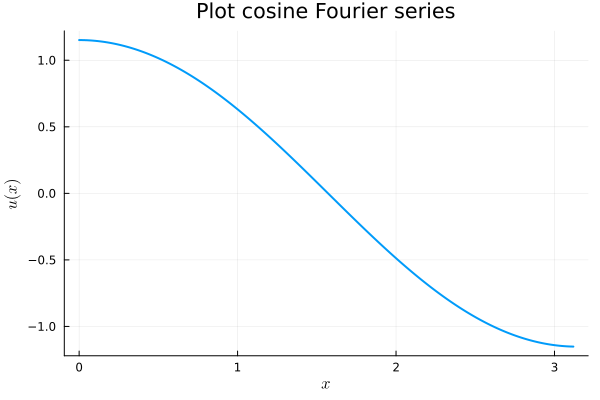

In [28]:
# c̄ = [0;0;.5;zeros(N-2)]
plot_cos(ū)
# savefig("steadystateSH.pdf")

In [11]:
# solve Swift-Hohenberg via RadiiPolynomal.jl
function F!(F, u, λ)
    ∂² = project(Derivative(2), space(u), space(u))
    project!(F, λ * u - (I + ∂²)^2 * u - u^3)
    return F
end

function DF!(DF, u, λ)
    ∂² = project(Derivative(2), space(u), space(u))
    add!(DF, λ * I - (I + ∂²)^2, Multiplication(-3u^2))
    return DF
end


DF! (generic function with 1 method)

In [45]:
using RadiiPolynomial
N = 20
λ = 6.0
# u = Sequence(CosFourier(N, 1.0), rand(N+1))
u = Sequence(CosFourier(N, 1.0/3.0), 100*randn(N+1)./(1:N+1).^2)
# 100*randn(N)./(1:N).^2

newton!((F, DF, u) -> (F!(F, u, λ), DF!(DF, u, λ)), u, maxiter = 100)

Newton's method: Inf-norm, tol = 1.0e-12, maxiter = 100
      iteration        |F(x)|
-------------------------------------
          0          2.0140e+05        |DF(x)\F(x)| = 1.9942e+01
          1          5.9653e+04        |DF(x)\F(x)| = 1.3276e+01
          2          1.7660e+04        |DF(x)\F(x)| = 8.8224e+00
          3          5.2228e+03        |DF(x)\F(x)| = 5.8413e+00
          4          1.5408e+03        |DF(x)\F(x)| = 3.8394e+00
          5          4.5189e+02        |DF(x)\F(x)| = 2.4784e+00
          6          1.3063e+02        |DF(x)\F(x)| = 1.5250e+00
          7          3.6426e+01        |DF(x)\F(x)| = 8.4257e-01
          8          9.3157e+00        |DF(x)\F(x)| = 3.8732e-01
          9          1.9467e+00        |DF(x)\F(x)| = 1.2844e-01
         10          2.3809e-01        |DF(x)\F(x)| = 2.0259e-02
         11          7.0258e-03        |DF(x)\F(x)| = 2.1747e-01
         12          2.6509e-01        |DF(x)\F(x)| = 2.5491e-02
         13          6.9157e-03

(Sequence(CosFourier(20, 0.3333333333333333), [-0.42410638978601617, 1.3727200554317611, 0.40932125439108885, -0.30001976347698406, -0.2950871008335348, 0.01536583360571052, 0.09666191416505372, 0.023910839890781712, -0.016192794168221347, -0.010146294528884872  …  0.00254981655426797, 0.0005102758238633763, -0.00042279450272984066, -0.0002265650797013224, 2.9485378068914953e-5, 5.626165920688516e-5, 8.919223199736317e-6, -9.401504242494276e-6, -4.3712724499450765e-6, 7.796710296239939e-7]), true)

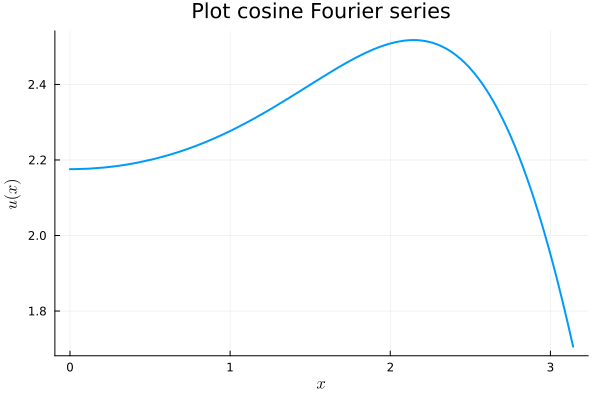

In [46]:
# u = Sequence(CosFourier(N, 1.0), [0;.5;zeros(N-1)])
plot(x -> u(x),0 ,π, legend=false, title = "Plot cosine Fourier series",
        line=2,
        xlabel = "\$x\$",
        ylabel = "\$u(x)\$",)
# savefig("steadystate2SH.pdf")

# $A^\dagger$, $A$の計算

In [33]:
DF_ū

10×10 Matrix{Float64}:
 -2.01031      -1.23629e-11  …      2.47038e-7      -3.88483e-17
 -6.18145e-12  -2.00507            -7.48196e-17      1.2323e-7
 -0.994766     -6.14728e-12        -4.46218e-5      -5.53954e-17
  3.41678e-14  -0.984424            1.38636e-16     -4.46215e-5
  0.0103425     3.43064e-14         0.0103425        1.49141e-16
  1.38636e-16   0.0102979    …      3.41783e-14      0.0103425
 -4.46215e-5    8.32406e-17        -0.994766         3.41212e-14
 -5.53954e-17  -4.4498e-5          -6.1815e-12      -0.994766
  1.23519e-7   -7.48196e-17     -3970.01            -6.18148e-12
 -1.94242e-17   1.2323e-7          -6.18148e-12  -6401.01

In [29]:
DF_ū = DF_equilibrium(ū,λ) # DF^{(m)}(c̄^{(m)})
Am = inv(DF_ū)

10×10 Matrix{Float64}:
 -0.551788      3.09387e-12   0.109834     …  -3.01066e-9    3.18609e-21
  1.54693e-12  -0.502471     -3.57559e-15      9.20696e-21  -1.06696e-10
  0.0549168    -3.57559e-15  -0.110975         2.87232e-9    4.96016e-22
 -2.89121e-14   0.00760904    1.06172e-14      7.23588e-22   1.64203e-10
 -0.000266976  -1.26461e-16   0.000493503     -1.24391e-8    1.28953e-23
  8.34195e-17  -2.20857e-5   -3.01748e-17  …  -1.81366e-20  -2.91676e-9
  6.99984e-7    2.4874e-19   -1.34061e-6       2.04389e-7   -4.87045e-21
 -1.85322e-19   5.33732e-8    6.3254e-20       6.74861e-19   6.7423e-8
 -1.50533e-9    9.20696e-21   2.87232e-9      -0.000251889   2.43146e-19
  1.59305e-21  -1.06696e-10   4.96016e-22      2.43146e-19  -0.000156225

# $Y_0$評価

In [34]:
wnorm(ones(3),1.2)

6.279999999999999

In [19]:
using LinearAlgebra

function wnorm(a,ν)
    m = length(a)
    nu_power = [1; 2*ν.^(1:m-1)]
    return sum(abs.(a).*nu_power)
end

function wnorm_mat(M,ν)
    m = size(M,2)
    nu_power = [1; 2*ν.^(1:m-1)]
    return maximum(sum(abs.(M) .* nu_power, dims=1)./nu_power')
end

wnorm_mat (generic function with 1 method)

In [41]:
ν = 1.0
m = length(ū)
function F_ext(c,λ) # Input: cosine Fourier
    N = length(c)-1 # maximum wave (N = m-1)
    c_ext = zeros(3N+1)
    c_ext[1:N+1] = c
    k = (0:3N)
    c3 = cubiccos(c,c,c)
    return λ*c_ext - (1 .- k.^2).^2 .* c_ext - c3
    # -k.^2*omega^2 .* a + a2[N+1:end]
end
f_ū = F_ext(ū,λ)
fm = f_ū[1:m]

k = m:3*(m-1)
μ = λ .-  (1 .- k.^2).^2

f_ū[1:m] .= 0
f_ū[m+1:end] = f_ū[m+1:end] ./ μ

Y0 = wnorm(Am*fm,ν) + wnorm(f_ū,ν)

5.419412526522383e-12

# $Z_0$評価

In [22]:
Z0 = wnorm_mat(I - Am * DF_ū,ν)

3.329383969695158e-16

# $Z_1$評価

In [23]:
Ψ = zeros(m)
c2_ext = zeros(6(m-1))
c2 = powerconvcos(ū,2)
c2_ext[1:2(m-1)+1] = c2


for k = 0:m-1
    tmp = 0
    for k1 = m:k+2(m-1)
        # @show c2_ext[abs(k-k1)+1] + c2_ext[abs(k+k1)+1]
        tmp = max(tmp, abs(c2_ext[abs(k-k1)+1] + c2_ext[abs(k+k1)+1])/(2ν^(k1)))
    end
    Ψ[k+1] = tmp
end
μₘ = λ .- (1 .- m^2)^2
Z1 = wnorm(3*Am*Ψ,ν) + 3*wnorm(c2,ν)/abs(μₘ)

0.0008291442378699915

# $Z_2$評価

In [24]:
function Mopnorm(M,ν,δ)
    return max(wnorm_mat(M,ν),δ)
end
A_opnorm = Mopnorm(Am,ν,1/abs(μₘ))
c1 = wnorm(ū,ν)

Z2(r) = 3*A_opnorm*(r+2*c1)

Z2 (generic function with 1 method)

# Radii-polynomial

In [25]:
c1

1.1636335038471555

In [26]:
p(r) = Z2(r)*r^2 - (1-Z0-Z1)*r + Y0

p (generic function with 1 method)

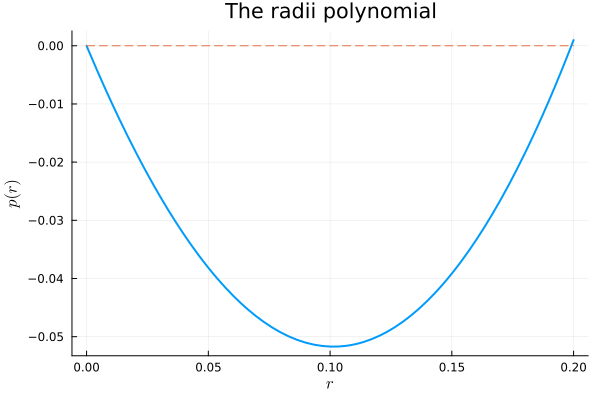

In [27]:
plot(p,0,0.2,
    line = 2,
    legend = false,
    title = "The radii polynomial",
    xlabel = "\$r\$",
    ylabel = "\$p(r)\$",
)
plot!(x->0,0,0.2,linestyle=:dash)